In [1]:
import os
import contextily as cx
from bigdata.utils import read_files


FILE_PATH = os.getcwd()
ROOT_DIR = FILE_PATH.split("src")[0]
DATA_DIR = ROOT_DIR + "data"

In [2]:
ddf = read_files(
    os.path.join(DATA_DIR, "csv"),
    file_format="csv",
    usecols=["Street Code1", "Street Code2", "Street Code3", 'Violation Post Code'],
    dtype={"Street Code1": "int", "Street Code2": "int", "Street Code3": "int", 'Violation Post Code': 'object'},
    years=list(range(2014, 2024)),
)
ddf = ddf[~ddf["Violation Post Code"].isna()]
ddf = ddf[ddf["Street Code1"] != 0]
ddf = ddf[ddf["Street Code2"] != 0]
ddf = ddf[ddf["Street Code3"] != 0]
ddf["count"] = 1
ddf = (
    ddf.groupby(["Street Code1", "Street Code2", "Street Code3", "Violation Post Code"]).count().reset_index()
)
ddf = ddf.sort_values(by="count", ascending=False, inplace=True)
streets = ddf.head(20)

In [3]:
streets

,Street Code1,Street Code2,Street Code3,Violation Post Code,count
1254,44750,10575,10575,09-P,27152
358,34370,10810,10910,99,24740
338,34430,10410,13610,99,19449
320,34330,10510,10610,99,16280
379,34310,10510,10610,99,15003
305,34110,10610,10810,99,13040
552,77150,47520,57720,01,12593
330,34290,10510,10610,99,12409
348,34430,10510,10610,99,11379
324,34310,13610,10510,99,10545


In [4]:
ddf = read_files(
    os.path.join(DATA_DIR, "csv"),
    file_format="csv",
    usecols=["Street Code1", "Street Code2", "Street Code3", "Street"],
    dtype={"Street Code1": "int", "Street Code2": "int", "Street Code3": "int", 'Street': 'str'},
    years=list(range(2014, 2015)),
)

In [5]:
ddf['Street Code'] = ddf['Street Code1'].astype(str) + '-' + ddf['Street Code2'].astype(str) + '-' + ddf['Street Code3'].astype(str)
ddf = ddf.drop(columns=['Street Code1', 'Street Code2', 'Street Code3'])

In [6]:
streets['Street Code'] = streets['Street Code1'].astype(str) + '-' + streets['Street Code2'].astype(str) + '-' + streets['Street Code3'].astype(str)

In [7]:
df = ddf.compute()
df = df[df['Street Code'].isin(streets['Street Code'])]
df.Street = df.Street.str.replace('W ', 'WEST ')
df.drop_duplicates(subset=['Street Code'], inplace=True)

In [8]:
streets = streets.merge(df, on='Street Code', how='left')

In [9]:
streets.head(10).to_csv(os.path.join(DATA_DIR, 'top_10_streets.csv'), index=False)

In [10]:
all_dtype={'Violation Description': 'object',
       'Violation Legal Code': 'object',
       'Violation Post Code': 'object', 'Intersecting Street': 'object',
       'Issuer Squad': 'object',
       'Time First Observed': 'object', 'Vehicle Expiration Date': 'object', 'House Number': 'object'}

In [11]:
ddf = read_files(
    os.path.join(DATA_DIR, "csv"),
    file_format="csv",
    usecols=["Street Code1", "Street Code2", "Street Code3", 'House Number'],
    dtype={"Street Code1": "int", "Street Code2": "int", "Street Code3": "int", 'House Number': 'object'},
    years=list(range(2015, 2024)),
)

In [12]:
ddf['Street Code'] = ddf['Street Code1'].astype(str) + '-' + ddf['Street Code2'].astype(str) + '-' + ddf['Street Code3'].astype(str)
ddf = ddf.drop(columns=['Street Code1', 'Street Code2', 'Street Code3'])
ddf = ddf.loc[ddf['Street Code'].isin(streets['Street Code'])]

In [13]:
df = ddf.compute()

In [14]:
import numpy as np
from tqdm import tqdm
import geopandas
from geodatasets import get_path
import matplotlib.pyplot as plt

In [15]:
def get_address(street, house_number):
    addr = ' '.join([x.capitalize() for x in f"{house_number} {street}, New York, NY".split(' ')])
    if 'West' in addr:
         addr += ', Manhattan'
    return addr

def parse_house_number(house_number):
        try:
            return int(house_number)
        except:
            return 0
        
street_locations = dict()
street_borders = dict()
for index, row in streets.head(10).iterrows():
    house_numbers = df.loc[df['Street Code'] == row['Street Code'], 'House Number']
    
        
    house_numbers = house_numbers.apply(parse_house_number)
    house_numbers = house_numbers[house_numbers != 0]
    street_borders[row['Street']] = {'min': house_numbers.min(), 'max': house_numbers.max()}
    min_house_number = house_numbers.min()
    max_house_number = house_numbers.max()
    max_location = geopandas.tools.geocode(get_address(row['Street'], max_house_number), provider='arcgis')
    min_location = geopandas.tools.geocode(get_address(row['Street'], min_house_number), provider='arcgis')
    street_locations[row['Street']] = [min_location, max_location]

In [16]:
ymin = 40.5
ymax = 40.9
xmin = -74.25
xmax = -73.7

grid = np.zeros((1000, 1000))

def get_cell_from_lat_lon(lat, lon):
    x = int((lon - xmin) / (xmax - xmin) * 1000)
    y = int((lat - ymin) / (ymax - ymin) * 1000)
    return x, y

In [17]:
locations = []
for index, row in streets.head(10).iterrows():
    street_name = row['Street']
    house_numbers = df.loc[df['Street Code'] == row['Street Code'], 'House Number']
    house_numbers = house_numbers.apply(parse_house_number)
    min_loc = street_locations[street_name][0].geometry
    max_loc = street_locations[street_name][1].geometry
    max_house_number = street_borders[street_name]['max']
    min_house_number = street_borders[street_name]['min']
    
    for house_number in tqdm(house_numbers, desc=street_name):
        if house_number == 0:
            lat = (min_loc.y + max_loc.y) / 2
            lon = (min_loc.x + max_loc.x) / 2
        else:
            n = (house_number - max_house_number) / (min_house_number - max_house_number)
            lat = min_loc.y + n * (max_loc.y - min_loc.y)
            lon = min_loc.x + n * (max_loc.x - min_loc.x)
        point = geopandas.points_from_xy(lon.values, lat.values)[0]
        locations.append(point)

gdf = geopandas.GeoDataFrame(geometry=locations)

WEST 27 ST: 100%|██████████| 34515/34515 [00:34<00:00, 987.85it/s] 


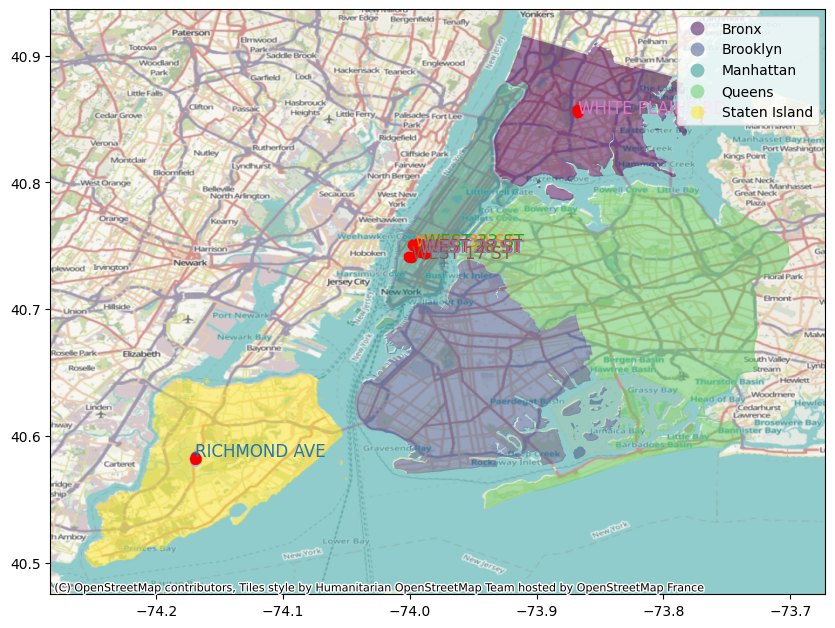

In [18]:
boroughs = geopandas.read_file(get_path("nybb")).to_crs(epsg=4326)

fig, ax = plt.subplots(figsize=(10, 10))
boroughs.plot("BoroName", legend=True, ax=ax, cmap="viridis", alpha=0.5)
# gdf.sample(frac=0.1).plot(ax=ax, color="red", alpha=0.1)

colors = plt.cm.tab20.colors
for i, (street, locations) in enumerate(street_locations.copy().items()):
    c1, c2 = colors[2*i], colors[2*i + 1]
    # print(street)
    min_loc, max_loc = locations
    min_loc.plot(ax=ax, color=c1)
    max_loc.plot(ax=ax, color=c2)
    ax.text(min_loc.geometry.x, min_loc.geometry.y, street, fontsize=12, color=c1)
nx = np.random.randn(gdf.shape[0]) * 0.001
ny = np.random.randn(gdf.shape[0]) * 0.001
ax.scatter(gdf.geometry.x + nx, gdf.geometry.y + ny, color="red", alpha=0.1, s=1)

# use underlying map
cx.add_basemap(ax, crs=boroughs.crs)

plt.savefig(os.path.join(ROOT_DIR, 'T3_figures', 'top_10_streets.png'))

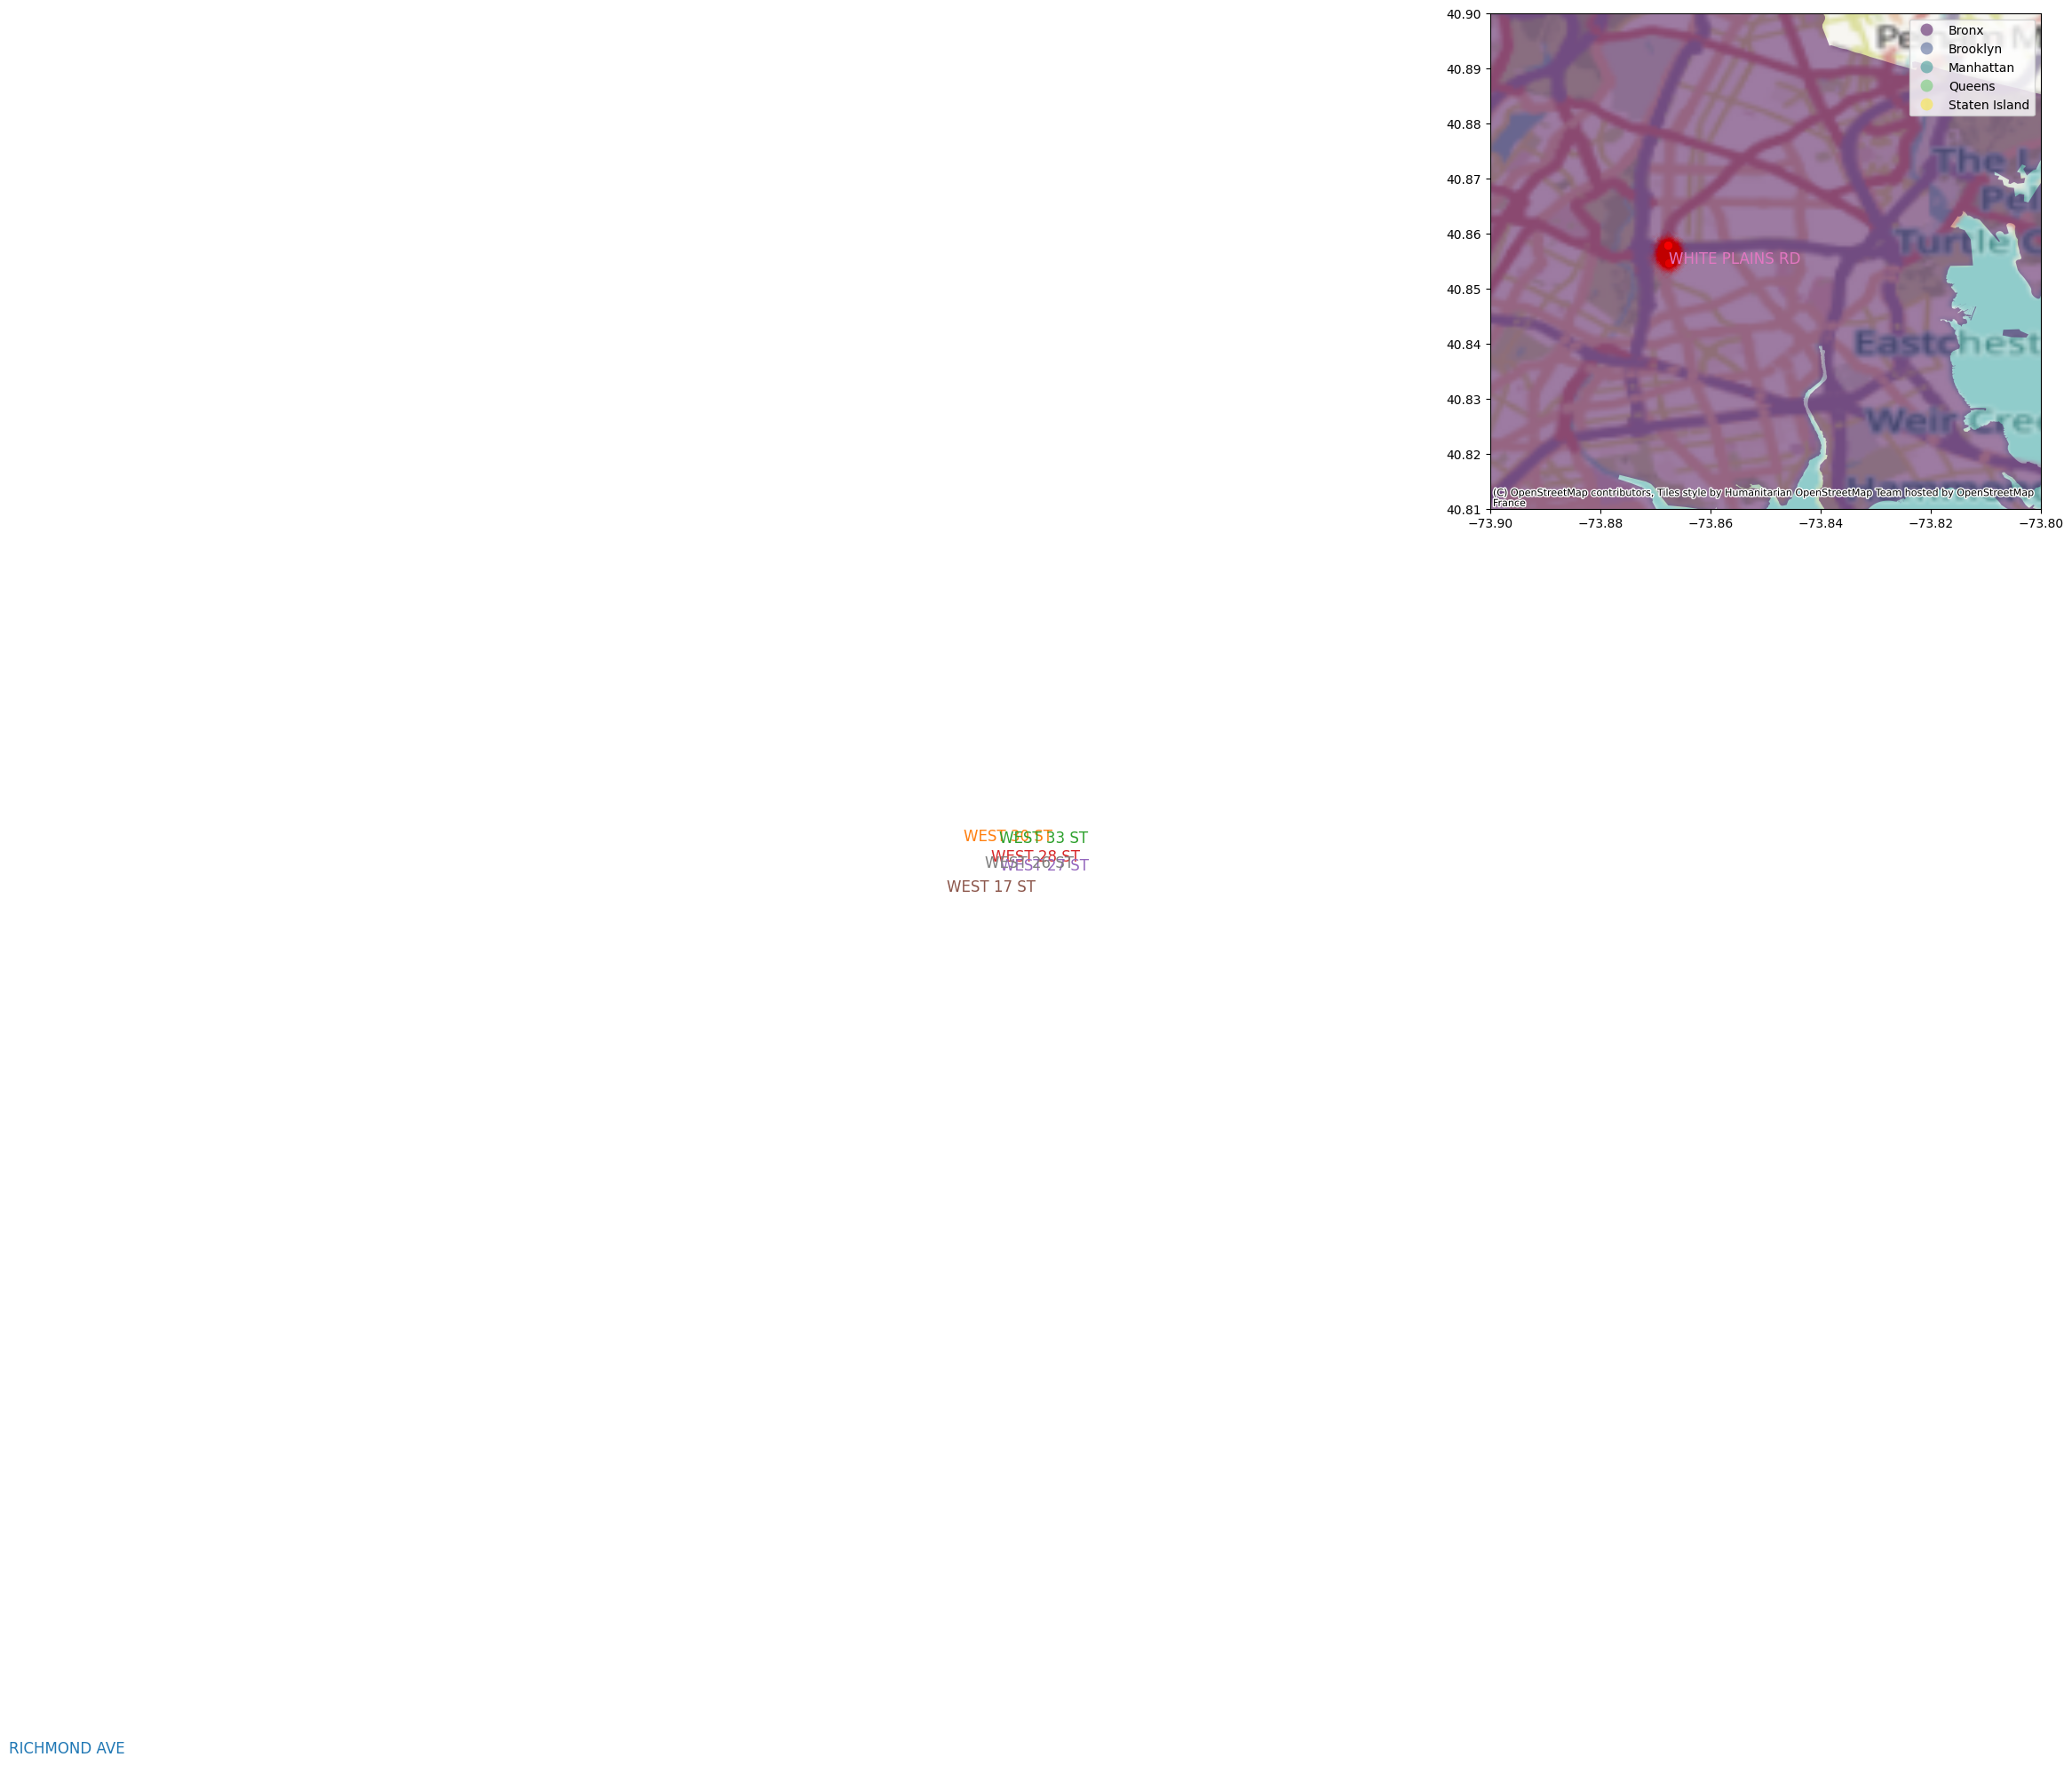

In [32]:
boroughs = geopandas.read_file(get_path("nybb")).to_crs(epsg=4326)

fig, ax = plt.subplots(figsize=(8, 8))
boroughs.plot("BoroName", legend=True, ax=ax, cmap="viridis", alpha=0.5)
# gdf.sample(frac=0.1).plot(ax=ax, color="red", alpha=0.1)

colors = plt.cm.tab20.colors
for i, (street, locations) in enumerate(street_locations.copy().items()):
    c1, c2 = colors[2*i], colors[2*i + 1]
    # print(street)
    min_loc, max_loc = locations
    min_loc.plot(ax=ax, color=c1)
    max_loc.plot(ax=ax, color=c2)
    ax.text(min_loc.geometry.x, min_loc.geometry.y, street, fontsize=12, color=c1)
nx = np.random.randn(gdf.shape[0]) * 0.001
ny = np.random.randn(gdf.shape[0]) * 0.001
ax.scatter(gdf.geometry.x + nx, gdf.geometry.y + ny, color="red", alpha=0.1, s=0.01)

# use underlying map
cx.add_basemap(ax, crs=boroughs.crs)

# ax.set_xlim(-74.02, -73.96)
# ax.set_ylim(40.73, 40.76)

ax.set_xlim(-73.9, -73.8)
ax.set_ylim(40.81, 40.9)

plt.savefig(os.path.join(ROOT_DIR, 'T3_figures', 'top_10_streets_zoom2.png'))